In [1]:
import os
import torch
from src.transformer_torch import *
from src.tokenizer import *
from src.utils import *

/home/nemit/Projects/mlgroup1/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = './model/checkpoints/gpt_model_shakesphere.pth'
model = torch.load(model_path)

/tmp/ipykernel_27359/524559339.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [3]:
tokenizer_path = './model/tokenizer_shakesphere.json'
tokenizer = load_tokenizer(tokenizer_path)
vocab_size = len(tokenizer.token_map)

In [4]:
checkpoint = torch.load(model_path, map_location='cpu')
embedding_dim = checkpoint.get('embedding_dim', 1024)
max_seq_len = checkpoint.get('max_seq_len', 1024)
heads = checkpoint.get('heads', 8)
ff_expand_dim = checkpoint.get('ff_expand_dim', 2)
blocks = checkpoint.get('blocks', 2)
lr = checkpoint.get('lr', 0.001)

model = GPT(vocab_size=vocab_size, 
            embed_size=embedding_dim, 
            max_seq_len=max_seq_len, 
            num_heads=heads, 
            ff_expand=ff_expand_dim, 
            num_blocks=blocks, 
            dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])

/tmp/ipykernel_27359/2039883398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def generate_sequence(model: nn.Module, 
                      initial_input: torch.Tensor, 
                      max_length: int, 
                      tokenizer: BytePairTokenizer,
                      stop_on_repeat: bool = True,
                      device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> torch.Tensor:
    model.eval()
    initial_input = initial_input.to(device)
    input_seq = initial_input.unsqueeze(0)  # (1, seq_len)
    text = tokenizer.decode(initial_input.tolist())
    with torch.no_grad():
        for _ in range(max_length - initial_input.size(0)):
            seq_len = input_seq.size(1)
            attn_mask = generate_causal_mask(seq_len, device=device)
            logits = model(input_seq, attn_mask=attn_mask)  # (1, seq_len, vocab_size)
            next_token_probs = F.softmax(logits[:, -1, :], dim=-1)  
            next_token = torch.argmax(next_token_probs, dim=-1)  # greedy
            input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)

            if input_seq.size(1) > model.max_seq_len:
                input_seq = input_seq[:, -model.max_seq_len:]
            
            text += tokenizer.decode(next_token.tolist())
            if stop_on_repeat and check_output_reproduction(text):
                break

    return input_seq.squeeze(0)

def check_output_reproduction(generated_text: str, repeat_threshold: int = 20, repeat_length: int = None) -> bool:
    if repeat_length is None:
        repeat_length = len(generated_text) // 10
    
    for i in range(len(generated_text) - repeat_length):
        for j in range(5, repeat_length):
            if generated_text[i:i+j] == generated_text[i+j:i+2*j]:
                if j >= repeat_threshold:
                    return True
    return False

def generate_text(input: str, max_tokens: int = 100, stop_on_repeat: bool = True) -> str:
    input_tokens = tokenizer.encode(input)
    input_tokens = torch.tensor(input_tokens)
    model.eval()
    output_tokens = generate_sequence(model, 
                                      input_tokens, 
                                      max_tokens, 
                                      tokenizer=tokenizer,
                                      stop_on_repeat=stop_on_repeat,
                                      device=torch.get_default_device())
    output_string = tokenizer.decode(output_tokens.tolist())
    return output_string

In [6]:
input = """First Citizen:
Before we proceed any further, hear me speak.

All:
Speak,"""
output = generate_text(input, max_tokens=1024)
print(output)

Finished splitting text into words in 9.441375732421875e-05 seconds


100%|██████████| 12/12 [00:00<00:00, 7061.12it/s]

Finished processing words in 0.16909146308898926 seconds
Function encode executed in 0:00:00.169336


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't, we know


In [7]:
# import matplotlib.pyplot as plt
# import random

# with open('./data/input.txt', 'r') as f:
#     data = f.read()

# data_split = data.split('\n')
# print(len(data_split))
# max_length = 1024

# viable_lengths = []
# for i in tqdm(range(1000)):
#     rand_start = random.randint(0, len(data_split)-100)
#     rand_length = random.randint(3, 7)
#     random_input = data_split[rand_start:rand_start+rand_length]
#     input_text = '\n'.join(random_input)
#     try:
#         random_output = generate_text(input_text, max_tokens=max_length, stop_on_repeat=True)
#     except Exception as e:
#         print(e)
#         viable_lengths.append(0)
#     viable_lengths.append(len(tokenizer.encode(random_output)))

In [8]:
print(viable_lengths)

NameError: name 'viable_lengths' is not defined

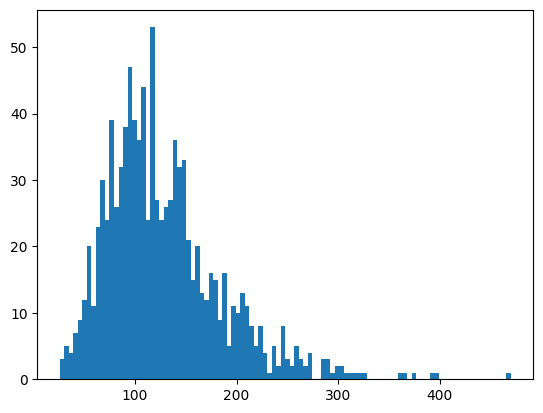

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.hist(viable_lengths, bins=100)
plt.show()
plt.savefig('output_lengths.png')
